In [55]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import os, sys
from keras_preprocessing.text import Tokenizer
from collections import Counter
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit
import re, string
from verstack.stratified_continuous_split import scsplit
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist 

from nltk.tokenize import word_tokenize
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ALike\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ALike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
df = pd.read_csv('step1_output.csv')
# df.drop('Unnamed: 0', axis=1).head(7)
# df.columns

pd.set_option("max_columns", 50)

data_DF = df[['retweet_count', 'text']]
print(data_DF.shape)
data_DF.head(10)

(172414, 2)


,retweet_count,text
0,0,More contagious UK coronavirus variant detecte...
1,0,"Biden leads observance of America's 400,000 CO..."
2,1,WORKING smoke alarms save lives! Check yours ...
3,0,24 million total U.S. Covid-19 infections were...
4,0,SIR Simulation of COVID-19 Pandemic in Malaysi...
5,0,"Expect changes to gatherings, personal service..."
6,0,Did alagari try out all the Pesticides manufac...
7,0,Harambe would have never let COVID-19 happen.
8,0,"When things feel uneasy in your life, refocus ..."
9,0,ICYMI: This hospital has been called Ontario’s...


In [57]:
# Shuffle the Dataset.
shuffled_train = data_DF.sample(frac=1, random_state=4)

# if you want to have a balanced dataset, uncomment following rows
'''
# Put all the samples where they dont have zeros re-tweet in a separate dataset.
non_zero_retweet = shuffled_train.loc[shuffled_train['retweet_count'] != 0]
nbr_samples = non_zero_retweet.shape[0] // 2

#Randomly select samples observations from the zero re-tweet (majority class)
zero_retweet = shuffled_train.loc[shuffled_train['retweet_count'] == 0].sample(n=nbr_samples, random_state=42)

print("Shape of non_zero_retweet: ", non_zero_retweet[:nbr_samples].shape)
print("Shape of zero_retweet: ", zero_retweet.shape)

# Concatenate both dataframes again
train_data = pd.concat([non_zero_retweet[:nbr_samples], zero_retweet])
#train_data_new = non_zero_retweet
print("Normalized train dataset: ", train_data.shape)
'''

train_data = shuffled_train

In [58]:
train_data_label = train_data.merge(train_data.retweet_count
                 .apply(lambda s: pd.Series({'target': 1 if s != 0 else 0})), left_index=True, right_index=True)

In [59]:
tweet_length = 200
x_train = train_data_label.copy(deep='true')
print("Shape Training Tweet Data: " + str(x_train.shape))
print("Maximum Tweet length: {}".format(len(max((x_train.text), key=len))))
print("Minimum Tweet length: {}".format(len(min((x_train.text), key=len))))
result = [len(x) for x in x_train]
print("Mean Tweet length: {}".format(np.mean(result)))

Shape Training Tweet Data: (172414, 3)
Maximum Tweet length: 164
Minimum Tweet length: 8
Mean Tweet length: 7.666666666666667


In [60]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# should be completed
def remove_extraspaces(text):
    # removing extra spaces
    return re.sub('+', ' ', temp_string).lower()

def remove_everythingexceptaz(text):
    # removing all everything except a-z english letters
    regex = re.compile('[^a-zA-Z]')
    return regex.sub(' ', temp_string)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [61]:
x_train['text'] = x_train['text'].apply(lambda x: remove_URL(x))
x_train['text'] = x_train['text'].apply(lambda x: remove_emoji(x))
x_train['text'] = x_train['text'].apply(lambda x: remove_html(x))
x_train['text'] = x_train['text'].apply(lambda x: remove_punct(x))
print(x_train.shape)
x_train.sample(5)

(172414, 3)


,retweet_count,text,target
59979,0,Is matching your mask to your dress a new fash...,0
152354,0,Local health experts say flu shots and COVID19...,0
24257,0,KonzerthausDO Study Reveals Masks Social Dista...,0
143897,0,atrupar Love it hes wearing a mask Amen I pra...,0
70828,0,This is what the current fore runners in the c...,0


In [62]:
# tokenizing
x_train['tokenized'] = x_train['text'].apply(word_tokenize)
x_train['lower'] = x_train['tokenized'].apply(lambda x: [word.lower() for word in x])
#removing stopwords
stop = set(stopwords.words('english'))
x_train['stopwords_removed'] = x_train['lower'].apply(lambda x: [word for word in x if word not in stop])
x_train['pos_tags'] = x_train['stopwords_removed'].apply(nltk.tag.pos_tag)


    
x_train['wordnet_pos'] = x_train['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
x_train.head()

KeyboardInterrupt: 

In [ ]:
# Applying word lemmatizer.
wnl = WordNetLemmatizer()
x_train['lemmatized'] = x_train['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
x_train['lemmatized'] = x_train['lemmatized'].apply(lambda x: [word for word in x if word not in stop])
x_train['lemma_str'] = [' '.join(map(str, l)) for l in x_train['lemmatized']]
x_train.head()

In [ ]:
print(len(max(x_train.stopwords_removed, key=len)))
x_train['lemma_str'] = x_train['lemma_str'].str.replace('\d+', '')

In [ ]:
x_train_final = pd.DataFrame(x_train['lemma_str'])
# x_train_final.head()
def counter_word(text_r):
    count = Counter()
    for i in text_r:
        for word_r in i.split():
            count[word_r] += 1
    return count

In [ ]:
x_train_final.values

In [ ]:
text = x_train_final["lemma_str"]
counter = counter_word(text)
num_words = len(counter)
print(num_words)
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train_final["lemma_str"])
word_index = tokenizer.word_index
word_index

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt',encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary-1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
words_list = list(tokenizer.word_index.keys())
print(len(words_list))
print(embedding_matrix.shape)

In [ ]:
# np.save('embedding.npy', np.asarray(embedding_matrix))
# np.save('words_list.npy', np.asarray(words_list))

# Dim reduction using tSNE  

In [24]:
from sklearn.manifold import TSNE  
# src: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models
def reduce_dimensions_my_version(words_list, embedding_matrix, sample=0):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)
    if sample > 0:
        lst = np.random.choice(len(words_list), sample, replace=False)
        labels = np.asarray(words_list)[lst]
        vectors = embedding_matrix[lst]
    # extract the words & their vectors, as numpy arrays
    else:
        vectors = np.asarray(embedding_matrix)
        labels = np.asarray(words_list)  # fixed-width numpy strings

    print(vectors.shape)
    print(labels.shape)
    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [25]:
x_vals, y_vals, labels = reduce_dimensions_my_version(words_list, embedding_matrix)

(109236, 300)
(109236,)


In [ ]:
def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

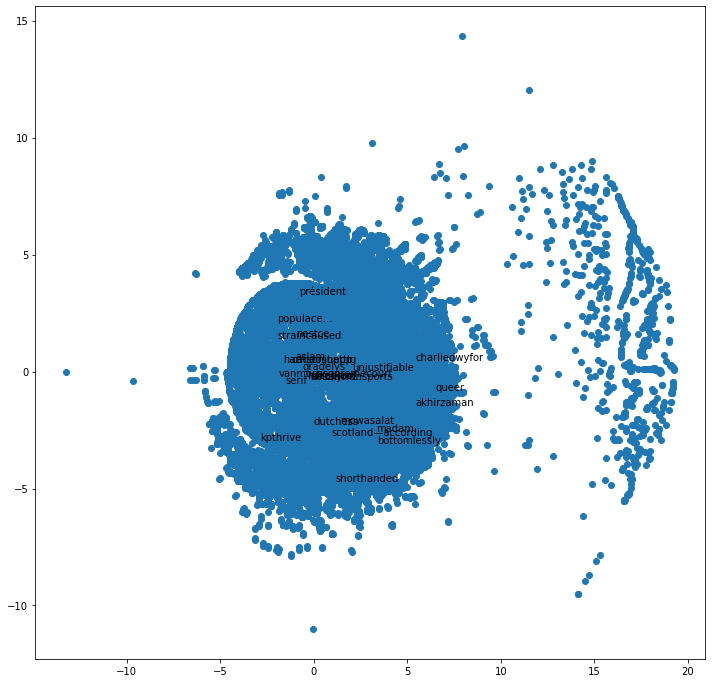

In [27]:
plot_with_matplotlib(x_vals, y_vals, labels)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [29]:
x_vals_DF = pd.DataFrame(x_vals, columns=['X'])
y_vals_DF = pd.DataFrame(y_vals, columns=['Y'])
labels_DF = pd.DataFrame(labels, columns=['label'])

In [76]:
data_df = pd.concat([x_vals_DF, y_vals_DF, labels_DF], axis=1)

In [77]:
data_df['label_num'] = data_df['label'].astype('category').cat.codes

In [78]:
data_df

,X,Y,label,label_num
0,1.415116,1.093354,covid,20523
1,0.764791,2.137699,coronavirus,19928
2,1.370624,4.132201,vaccine,101214
3,3.065107,-5.905045,’,108165
4,5.108501,-0.828660,new,65432
...,...,...,...,...
109231,0.983365,-0.215584,magder,57015
109232,-0.207612,-0.375963,drcopa,27440
109233,-1.318172,-1.649450,🥗,109012
109234,-4.137652,1.682848,travelgram…,97484


In [74]:
train_df, test_df = train_test_split(data_df.drop(['label'], axis=1), test_size=0.25, random_state=0)
data_df = train_df.to_numpy()
test_np = test_df.to_numpy()

kmeans = KMeans(init='k-means++', n_clusters=8, max_iter=10000, n_init=100).fit(data_df)
print("Train Clusters", kmeans.labels_)
print("Test Prediction: ", kmeans.predict(test_np))
print("Cluster Centers: ", kmeans.cluster_centers_)
print("SSE: ", kmeans.inertia_)

Train Clusters [2 7 2 ... 1 5 6]
Test Prediction:  [6 7 6 ... 0 7 0]
Cluster Centers:  [[2.73299914e-01 4.79954323e-02 7.56792677e+04]
 [3.04302615e-01 4.19654975e-02 3.40533226e+04]
 [1.99886984e-01 3.94169548e-02 1.02566196e+05]
 [2.24457407e-01 7.74968262e-02 6.70789006e+03]
 [1.76128043e-01 2.13366419e-02 4.80297053e+04]
 [2.39313171e-01 3.54717162e-03 2.02238069e+04]
 [2.18634292e-01 4.74416389e-02 8.91831749e+04]
 [1.61093441e-01 5.05315004e-02 6.19163762e+04]]
SSE:  1272154920408.036


# Dim reduction using PCA num_components = 2, 8

In [ ]:
from sklearn.decomposition import PCA
num_components = 2
two_dim = PCA().fit_transform(embedding_matrix)[:,:num_components]
num_components = 8
eight_dim = PCA().fit_transform(embedding_matrix)[:,:num_components]

# Clustering

In [65]:
x_vals_DF_2 = pd.DataFrame(two_dim)
labels_DF_2 = pd.DataFrame(labels, columns=['label'])
data_df_2 = pd.concat([x_vals_DF_2, labels_DF_2], axis=1)
data_df_2['label_num'] = data_df_2['label'].astype('category').cat.codes
train_df_2, test_df_2 = train_test_split(data_df_2.drop(['label'], axis=1), test_size=0.25, random_state=0)
train_np_2 = train_df_2.to_numpy()
test_np_2 = test_df_2.to_numpy()

kmeans_2 = KMeans(init='k-means++', n_clusters=19, max_iter=10000, n_init=100).fit(train_np_2)
print("Train Clusters", kmeans_2.labels_)
print("Test Prediction: ", kmeans_2.predict(test_np_2))
print("Cluster Centers: ", kmeans_2.cluster_centers_)
print("SSE: ", kmeans_2.inertia_)

Train Clusters [14  3  5 ... 10  4  1]
Test Prediction:  [ 1  6  1 ...  8 12 16]
Cluster Centers:  [[-1.11112463e-02 -1.26462497e-02  4.82294374e+04]
 [ 2.51596188e-02  1.97662080e-02  8.92855921e+04]
 [-1.57597026e-02  5.41598835e-03  1.33195325e+04]
 [-2.79843450e-02 -8.02176177e-03  6.60662567e+04]
 [-9.10452513e-03 -1.25419226e-02  2.51021458e+04]
 [-1.80490484e-02  9.66432067e-03  1.00888249e+05]
 [-1.51683825e-02 -8.95372885e-03  6.01286450e+04]
 [ 1.21700268e-03 -6.90078247e-03  9.50982747e+04]
 [ 4.51457734e-02  2.41201115e-02  7.77264508e+04]
 [-1.55350576e-03 -6.22155076e-03  2.54718595e+03]
 [ 9.65701166e-03  1.19413675e-02  3.67251190e+04]
 [ 4.25669763e-02  1.45780861e-02  1.91337679e+04]
 [-4.53425436e-02 -1.44911458e-02  5.41475687e+04]
 [ 1.09491368e-02  1.30604934e-02  3.09892899e+04]
 [-1.76358730e-02 -1.11380957e-02  1.06496511e+05]
 [ 3.50306626e-02  1.65106479e-02  7.19623683e+04]
 [ 1.95005804e-03 -9.81337661e-03  8.34615398e+04]
 [-2.07319754e-02 -5.65617765e-03 

In [83]:
labels = list(pd.merge(train_df_2, data_df.drop(['X', 'Y'], axis=1), on='label_num')['label'])

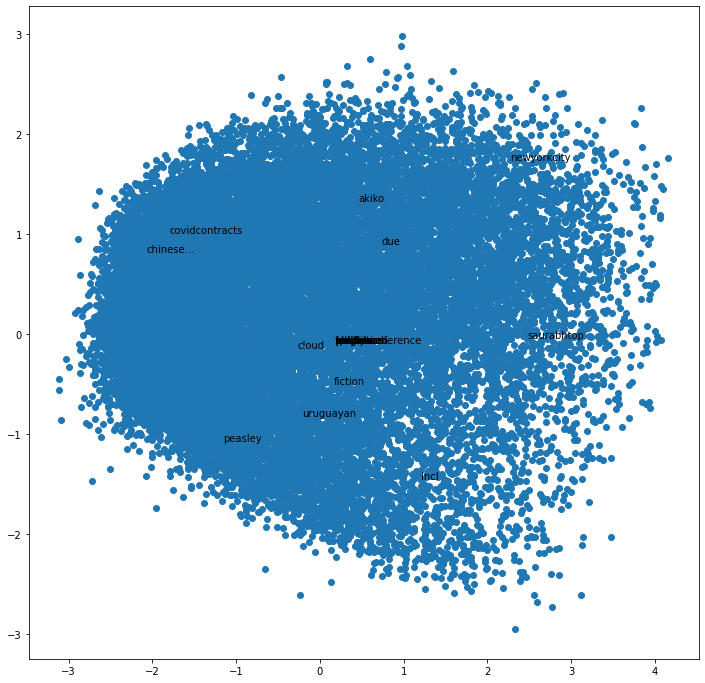

In [84]:
plot_with_matplotlib(list(train_df_2[0]), list(train_df_2[1]), labels)

In [34]:
x_vals_DF_8 = pd.DataFrame(eight_dim)
labels_DF_8 = pd.DataFrame(labels, columns=['label'])
data_df_8 = pd.concat([x_vals_DF_2, labels_DF_2], axis=1)
data_df_8['label_num'] = data_df_8['label'].astype('category').cat.codes
train_df_8, test_df_8 = train_test_split(data_df_8.drop(['label'], axis=1), test_size=0.25, random_state=0)
train_np_8 = train_df_8.to_numpy()
test_np_8 = test_df_8.to_numpy()

kmeans_8 = KMeans(init='k-means++', n_clusters=13, max_iter=10000, n_init=100).fit(train_np_8)
print("Train Clusters", kmeans_8.labels_)
print("Test Prediction: ", kmeans_8.predict(test_np_2))
print("Cluster Centers: ", kmeans_8.cluster_centers_)
print("SSE: ", kmeans_8.inertia_)

Train Clusters [3 6 3 ... 2 7 5]
Test Prediction:  [5 6 5 ... 1 6 1]
Cluster Centers:  [[-1.29934171e-02 -3.79133800e-03  3.27071207e-03 -2.02904571e-03
  -2.58467838e-03 -5.06219426e-03 -8.27784749e-03  1.27075101e-03
   6.82213801e+03]
 [ 3.14920230e-02  1.33786707e-02  3.79454021e-03 -4.42153295e-04
   5.36016937e-04  4.05002403e-03  1.38621253e-03 -1.60564556e-03
   7.52561599e+04]
 [ 5.88766154e-03  1.11889114e-02  8.45128283e-03 -1.93689841e-03
  -6.25183018e-03 -2.67380383e-03  3.75340366e-03  5.03125517e-03
   3.38827829e+04]
 [-1.36699940e-02  3.35847955e-03 -3.94114181e-03 -3.88026112e-03
   3.94928299e-03 -2.60949232e-03 -1.00157783e-03  1.30084021e-03
   1.02550208e+05]
 [-2.20871394e-02 -1.17292728e-02 -2.99006049e-03  3.25855991e-03
   2.64489966e-03 -7.67331431e-04  3.01817308e-03  4.88200993e-04
   4.74625815e+04]
 [ 1.11139978e-02  7.78154119e-04 -2.21240857e-03  2.13509623e-03
   2.69547150e-03  1.94258269e-03  3.22124367e-03 -2.25410991e-03
   8.90372860e+04]
 [-1.65

# Determine Optimal K for KMeans
https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

Two methods that can be useful to find this mysterious k in k-Means.
These methods are:
The Elbow Method
The Silhouette Method

## The Elbow Method
This is probably the most well-known method for determining the optimal number of clusters. It is also a bit naive in its approach.
Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.
Within-Cluster-Sum of Squared Errors sounds a bit complex. Let’s break it down:
The Squared Error for each point is the square of the distance of the point from its representation i.e. its predicted cluster center.
The WSS score is the sum of these Squared Errors for all the points.
Any distance metric like the Euclidean Distance or the Manhattan Distance can be used.

In [41]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
          curr_center = centroids[pred_clusters[i]]
          curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse
sse_8 = calculate_WSS(train_np_8, 20)
min_value_8 = min(sse_8)
print("Optimal number of cluster for 8 components is: ", sse_8.index(min_value_8))
sse_2 = calculate_WSS(train_np_8, 20)
min_value_2 = min(sse_2)
print("Optimal number of cluster for 2 components is: ", sse_2.index(min_value_2))

Optimal number of cluster for 8 components is:  13
Optimal number of cluster for 2 components is:  19


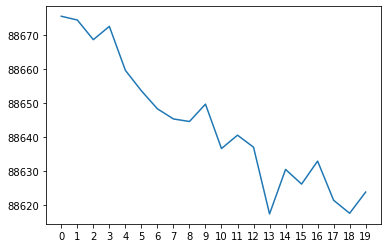

In [53]:
plt.plot(sse_8)
plt.xticks(np.arange(0, 20, 1))
plt.show()

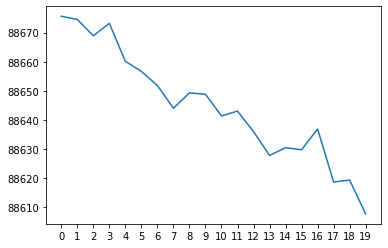

In [54]:
plt.plot(sse_2)
plt.xticks(np.arange(0, 20, 1))
plt.show()

## The silhouette 
value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).
Source: Wikipedia
The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

In [44]:
from sklearn.metrics import silhouette_score


def calculate_sil(points, kmax=10):
    sil = []
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    return sil

### a high Silhouette Score is desirable. The Silhouette Score reaches its global maximum at the optimal k. This should ideally appear as a peak in the Silhouette Value-versus-k plot.

In [46]:
sil_8 = calculate_WSS(train_np_8, 20)
max_value_8_sil = max(sil_8)
print("Optimal number of cluster for 8 components is: ", sil_8.index(max_value_8_sil))
sil_2 = calculate_WSS(train_np_8, 20)
max_value_2_sil = max(sil_2)
print("Optimal number of cluster for 2 components is: ", sil_2.index(max_value_2_sil))

Optimal number of cluster for 8 components is:  0
Optimal number of cluster for 2 components is:  0


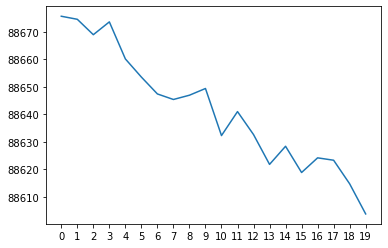

In [51]:
plt.plot(sil_8)
plt.xticks(np.arange(0, 20, 1))
plt.show()

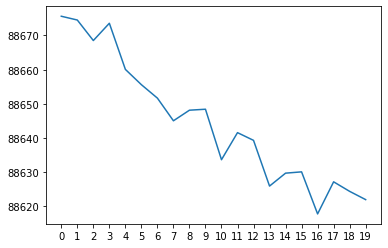

In [52]:
plt.plot(sil_2)
plt.xticks(np.arange(0, 20, 1))
plt.show()